In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import umap.umap_ as umap 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA



/Users/pjol/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2022-12-05 11:05:57.361232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
path = "data/"

data=pd.read_csv(path+'A2_data.csv')
X,y= data.loc[:, data.columns != 'class'], data['class']

print(f'There are {X.shape[0]} samples of each {X.shape[1]} features')

#Data includes some identifiers lets remove those 
ID_parameters= ['field_ID','MJD','plate', 'alpha', 'delta']
for ID in ID_parameters:
    X=X.loc[:, X.columns != ID]

#We know that a flux should be positive so remove the datapoint which does not have that
#This datapoint has value -9999 so not a detection but a instrumentation issue
I_remove=np.where(X['u']<0)[0]
X,y = X.drop(I_remove),y.drop(I_remove)
X,y=X.reset_index(drop=True),y.reset_index(drop=True)

print(f'There are final {X.shape[0]} samples of now {X.shape[1]} features')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
X_train,y_train=X_train.reset_index(drop=True),y_train.reset_index(drop=True)
X_test,y_test=X_test.reset_index(drop=True),y_test.reset_index(drop=True)

print(f'There are {X_train.shape[0]} training samples of each {X_train.shape[1]} features')

There are 100000 samples of each 11 features
There are final 99999 samples of now 6 features
There are 66999 training samples of each 6 features


In [48]:
X_train

,u,g,r,i,z,redshift
0,23.95943,20.98284,19.51513,18.91600,18.51377,0.0262
1,24.61096,20.84548,19.18086,18.44554,18.06229,6.4450
2,22.50775,21.15864,21.06297,20.36137,20.09062,-1.3030
3,22.99671,22.91850,22.99732,22.19737,22.11044,-3.3090
4,23.77238,22.02131,20.75401,19.59095,19.08693,1.2180
...,...,...,...,...,...,...
66994,20.82854,20.32382,20.25718,20.39426,20.36549,-0.6055
66995,18.93209,16.96611,16.05940,15.64639,15.30356,-2.3050
66996,23.95684,21.37612,19.75149,18.49137,17.77083,-0.3264
66997,17.79224,16.47265,15.84970,15.59104,15.46414,-3.1100


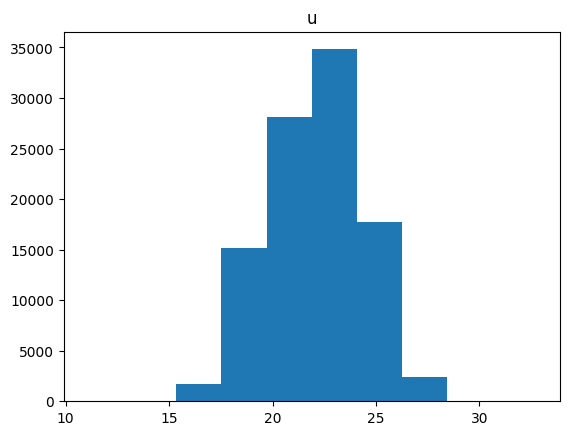

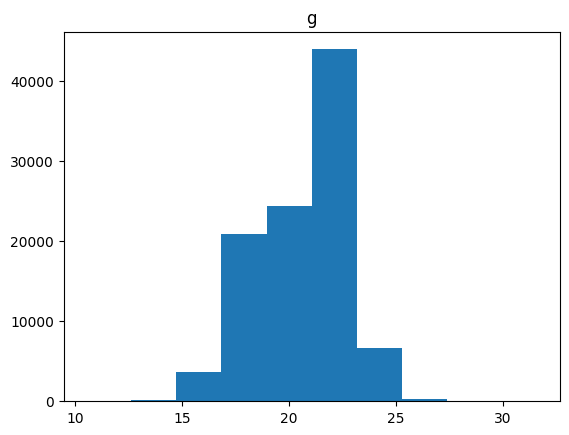

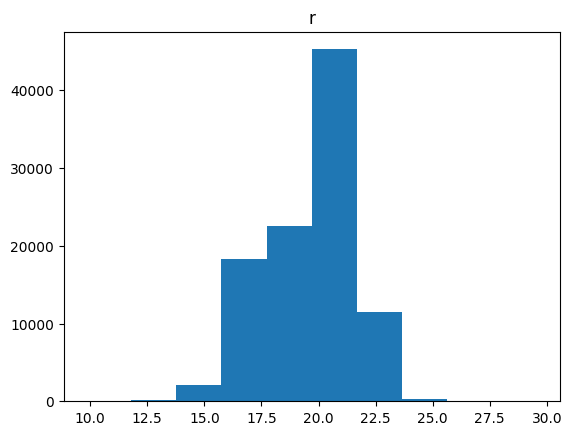

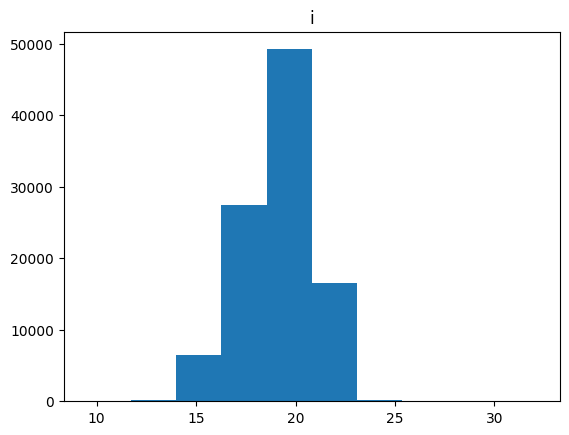

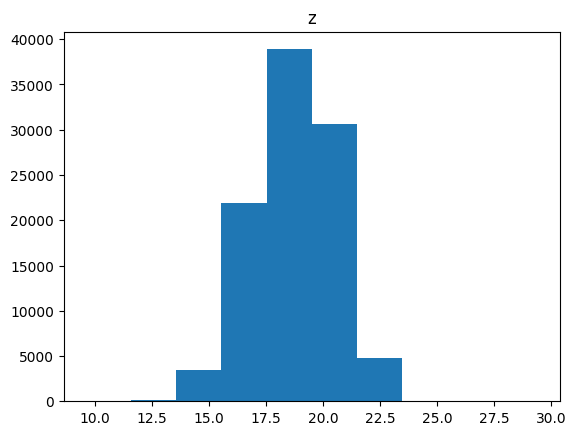

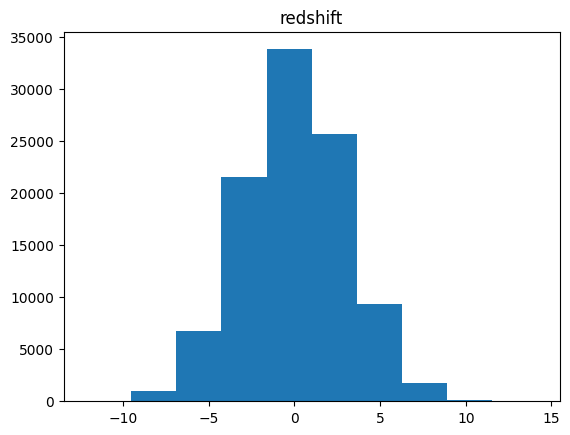

In [270]:
for C in X.columns:
    plt.hist(X[C])
    plt.title(C)
    plt.show()

In [44]:
#Visualise the models
def visualise_components(model_name, y, finaldim):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'2 component {model_name}', fontsize = 20)
    targets = np.unique(y)
    colors = ['r', 'g', 'b','k','y']
    for target, color in zip(targets,colors):
        indicesToKeep = finaldim['class'] == target
        ax.scatter(finaldim.loc[indicesToKeep, 'component 1']
                , finaldim.loc[indicesToKeep, 'component 2']
                , c = color
                , s = 10
                , marker = '.')
    ax.legend(targets, fontsize=15)
    ax.grid()
    plt.savefig(f'plots/{model_name}.pdf')
    plt.show()

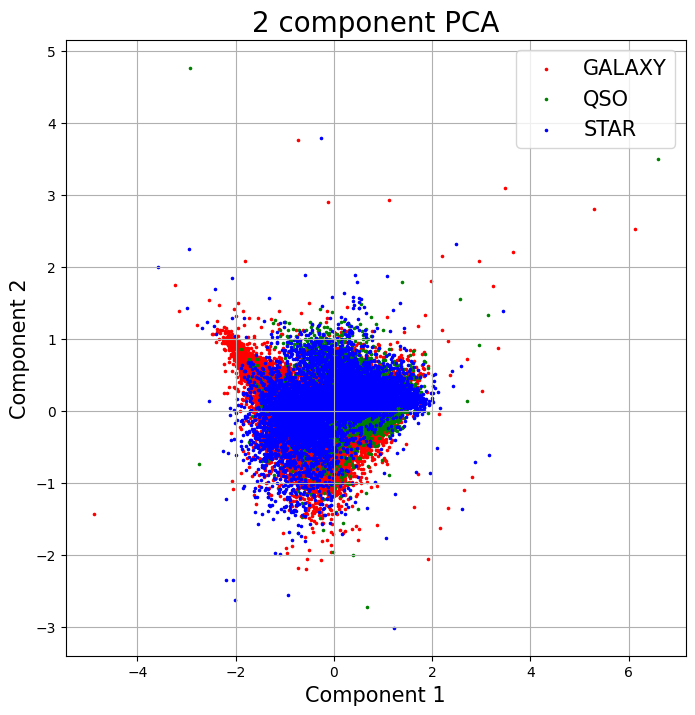

,component 3,component 4,component 1,component 2,class
0,-0.257216,0.001485,-0.785361,0.271234,GALAXY
1,-0.007930,2.131908,-1.245664,0.380831,GALAXY
2,-1.224737,-0.421312,0.476908,0.104186,GALAXY
3,-3.198119,-1.074957,1.092287,-0.051940,GALAXY
4,-1.099609,0.404389,-0.514019,-0.125046,GALAXY
...,...,...,...,...,...
66994,-0.617373,-0.181259,1.184341,0.181806,QSO
66995,4.069724,-0.780759,-0.239667,-0.035433,GALAXY
66996,-0.108340,-0.120891,-1.105773,-0.103611,STAR
66997,4.404377,-1.043434,0.233323,-0.071123,GALAXY


In [58]:
x = X_train
x = StandardScaler().fit_transform(x)


# Use PCA to reduce to two dimensions
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents,columns = ['component 3', 'component 4','component 1', 'component 2'])
finalPca = pd.concat([principal, y_train], axis = 1)

visualise_components('PCA', y_train, finalPca)

finalPca


In [78]:
params_list= [{
    "n_neighbors": 2,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 5,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 50,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 100,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 200,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
}

] #(0.0, 0.1, 0.25, 0.5, 0.8, 0.99)

In [85]:
params_list=[{
    "n_neighbors": 10,
    "min_dist": 0.0,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.1,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.25,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.4,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.45,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.5,
    "metric": "correlation", 
    "init": "random"
}]

In [87]:
params_list=[{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "correlation", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "euclidean", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "minkowski", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "mahalanobis", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "jaccard", 
    "init": "random"
},{
    "n_neighbors": 10,
    "min_dist": 0.3,
    "metric": "chebyshev", 
    "init": "random"
}]

In [90]:
for params in params_list:
    print(params['n_neighbors'])
    x = X_train
    reducer = umap.UMAP(n_neighbors=params['n_neighbors'],min_dist=params['min_dist'],metric=params['metric'],init=params['init'])
    UmapComponents = reducer.fit_transform(x)
    UmapDf = pd.DataFrame(data = UmapComponents,columns = ['component 1', 'component 2'])
    finalUmapDf = pd.concat([UmapDf, y_train], axis = 1)

    visualise_components(f"UMAP_metric={params['metric']}", y_train, finalUmapDf)
    finalUmapDf

10


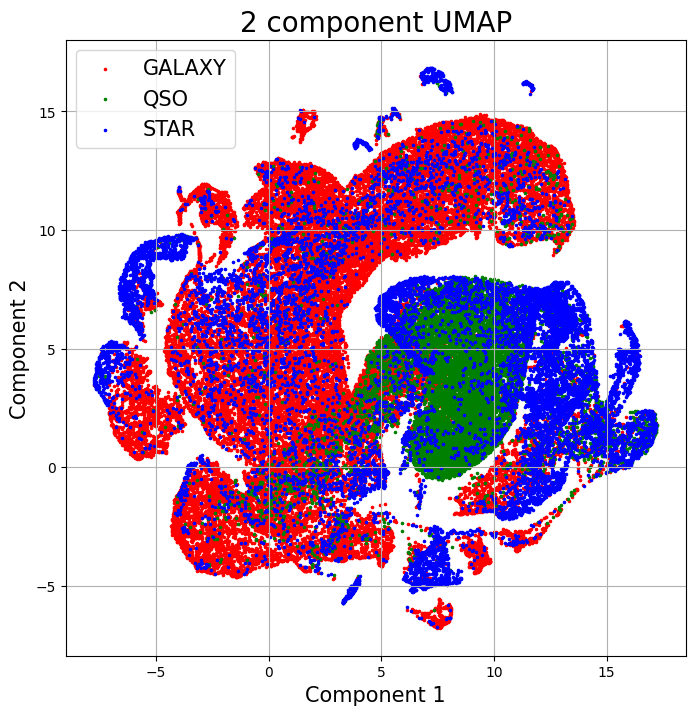

,component 1,component 2,class
0,3.824799,1.251923,GALAXY
1,8.045342,-5.912392,GALAXY
2,5.639346,2.578895,GALAXY
3,7.850933,3.345413,GALAXY
4,4.360051,10.368604,GALAXY
...,...,...,...
66994,10.209117,1.458336,QSO
66995,10.588270,-2.791911,GALAXY
66996,0.083594,6.078751,STAR
66997,10.130726,-1.961660,GALAXY


In [64]:

x = X_train
reducer = umap.UMAP(n_neighbors=10,min_dist=0.3,
                      metric='correlation',init='random')
UmapComponents = reducer.fit_transform(x)
UmapDf = pd.DataFrame(data = UmapComponents,columns = ['component 1', 'component 2'])
finalUmapDf = pd.concat([UmapDf, y_train], axis = 1)

visualise_components('UMAP', y_train, finalUmapDf)
finalUmapDf

In [52]:
#pd.concat([UmapDf, y_train], axis = 1)
print(len(UmapDf))
print(len(y_train))
np.where(y_train.isnull())

66999
66999


(array([], dtype=int64),)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 66999 samples in 0.057s...
[t-SNE] Computed neighbors for 66999 samples in 4.360s...
[t-SNE] Computed conditional probabilities for sample 1000 / 66999
[t-SNE] Computed conditional probabilities for sample 2000 / 66999
[t-SNE] Computed conditional probabilities for sample 3000 / 66999
[t-SNE] Computed conditional probabilities for sample 4000 / 66999
[t-SNE] Computed conditional probabilities for sample 5000 / 66999
[t-SNE] Computed conditional probabilities for sample 6000 / 66999
[t-SNE] Computed conditional probabilities for sample 7000 / 66999
[t-SNE] Computed conditional probabilities for sample 8000 / 66999
[t-SNE] Computed conditional probabilities for sample 9000 / 66999
[t-SNE] Computed conditional probabilities for sample 10000 / 66999
[t-SNE] Computed conditional probabilities for sample 11000 / 66999
[t-SNE] Computed conditional probabilities for sample 12000 / 66999
[t-SNE] Computed conditional probabilities for sam

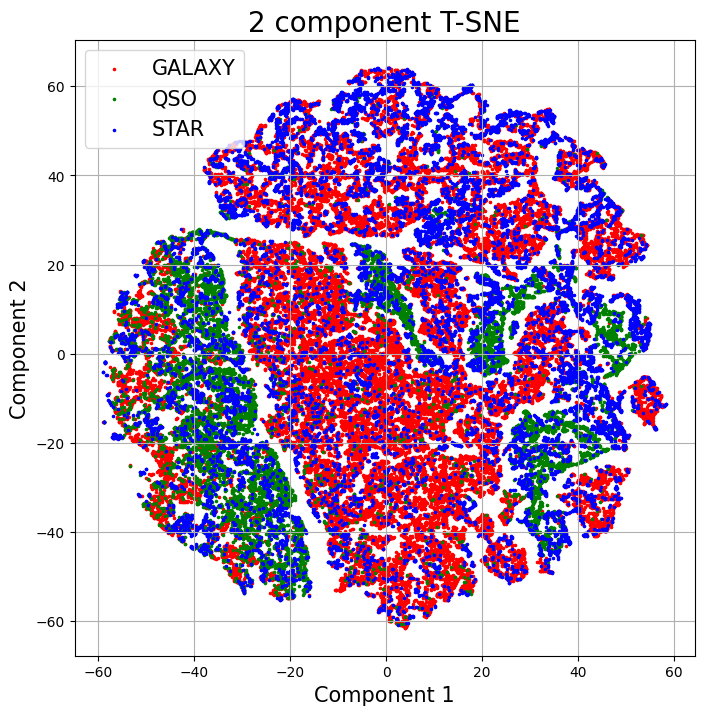

In [53]:
# Use T-SNE to reduce to two dimensions
x = X_train
tsne = TSNE(n_components=2, verbose=1)
tsneComponents = tsne.fit_transform(x)
tsneDf = pd.DataFrame(data = tsneComponents,columns = ['component 1', 'component 2'])
finalTsneDf = pd.concat([tsneDf, y_train], axis = 1)
finalTsneDf

visualise_components('T-SNE', y_train, finalTsneDf)

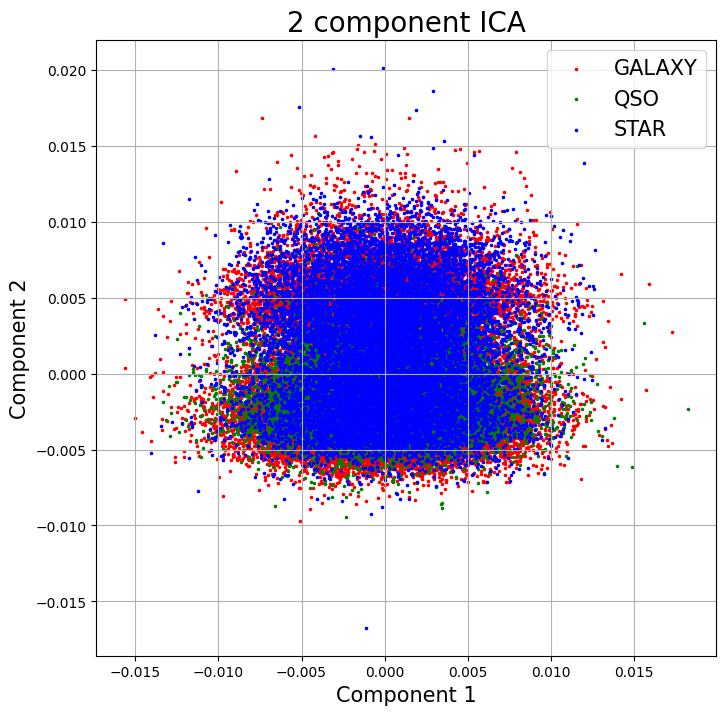

In [55]:
#Try ICA

transformer = FastICA(n_components=2,whiten='unit-variance')
icacomponents = transformer.fit_transform(x)
icaDf= pd.DataFrame(data = icacomponents,columns = ['component 1', 'component 2'])
icaDf = pd.concat([icaDf, y_train], axis = 1)
icaDf

visualise_components('ICA', y_train, icaDf)

False

3


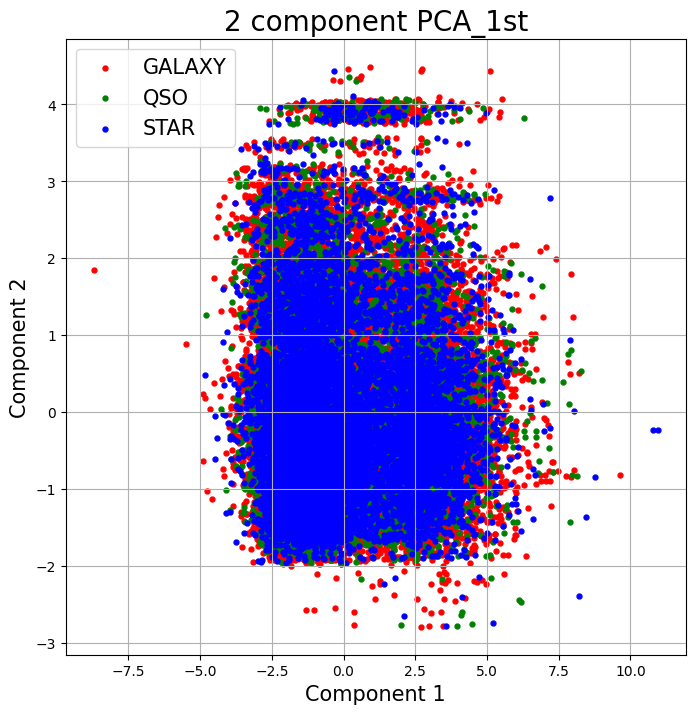

3


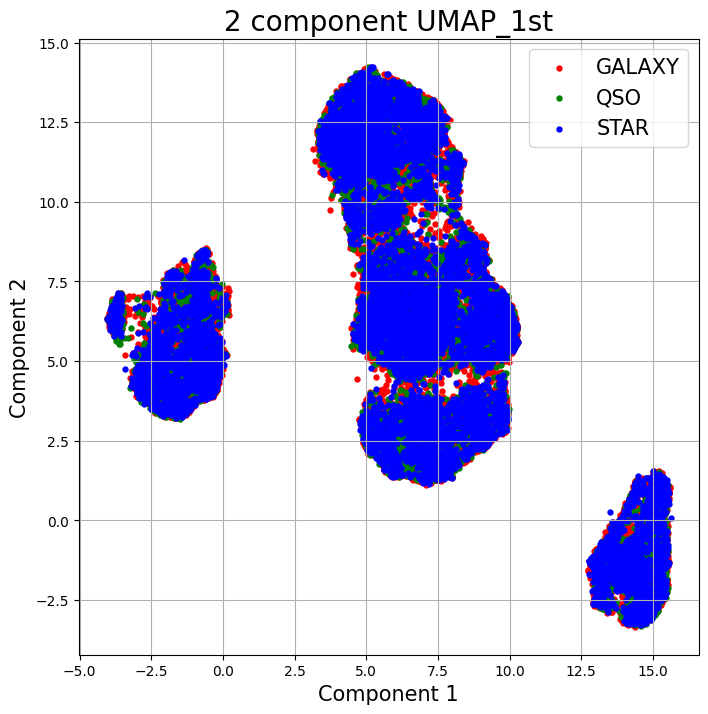

3


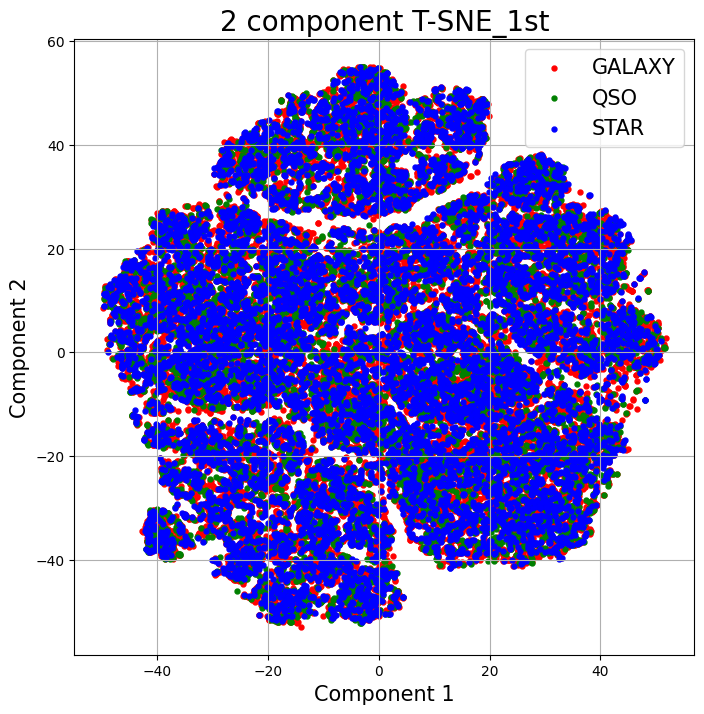

In [33]:
visualise_components('PCA_1st', y_train, finalPca)
visualise_components('UMAP_1st', y_train, finalUmapDf)
visualise_components('T-SNE_1st', y_train, finalTsneDf)